In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyts.datasets import make_cylinder_bell_funnel

In [20]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [21]:
random_state = 0

# IMPORT DATASET

In [22]:
dataset_name = "cbf"

In [23]:
X_all, y_all = make_cylinder_bell_funnel(n_samples = 600, random_state = random_state)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [24]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (600, 128, 1)
y SHAPE:  (600,)

CLASSES BALANCE
0 :  0.33
1 :  0.33
2 :  0.33


## DATASET SPLIT

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (268, 128, 1)
BLACKBOX VALIDATION SET:  (68, 128, 1)
BLACKBOX TEST SET:  (84, 128, 1)
EXPLANATION TRAINING SET:  (115, 128, 1)
EXPLANATION VALIDATION SET:  (29, 128, 1)
EXPLANATION TEST SET:  (36, 128, 1)


In [27]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  3


# BLACKBOX MODEL

In [28]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import UpSampling1D
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Dropout
from keras.layers import Reshape
from keras.utils import to_categorical
import time

In [29]:
import blackboxes

In [30]:
from blackboxes import *

In [31]:
import importlib
importlib.reload(blackboxes)

<module 'blackboxes' from '/Users/francesco/github/TS_AgnosticLocalExplainer/blackboxes.py'>

## resnet

In [32]:
blackbox = build_resnet(n_timesteps, n_outputs)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_resnet_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [34]:
blackbox.fit(X_train, y_train, epochs=5, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 268 samples, validate on 68 samples
Epoch 1/5
268/268 [==============================] - 7s 27ms/step - loss: 0.1785 - acc: 0.9366 - val_loss: 0.3121 - val_acc: 0.8235

Epoch 00001: val_acc improved from -inf to 0.82353, saving model to ./blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+0.82_.hdf5
Epoch 2/5
268/268 [==============================] - 3s 11ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.82353 to 1.00000, saving model to ./blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+1.00_.hdf5
Epoch 3/5
268/268 [==============================] - 3s 13ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 2.4003e-04 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/5
268/268 [==============================] - 3s 13ms/step - loss: 0.0075 - acc: 0.9963 - val_loss: 5.3953e-04 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/

### load best weights

In [35]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+1.00_.hdf5")

In [36]:
blackbox.evaluate(X_test, y_test)

84/84 [==============================] - 1s 18ms/step


[0.02825327261927582, 1.0]

In [37]:
resnet = blackbox

## simple CNN

In [36]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_simpleCNN_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 121, 16)           144       
_________________________________________________________________
batch_normalization_13 (Batc (None, 121, 16)           64        
_________________________________________________________________
activation_10 (Activation)   (None, 121, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 121, 16)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 117, 32)           2592      
_________________________________________________________________
batch_normalization_14 (Batc (None, 117, 32)           128       
_____

In [45]:
blackbox.fit(X_train, y_train, epochs=20, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 268 samples, validate on 68 samples
Epoch 1/20
268/268 [==============================] - 3s 11ms/step - loss: 0.9513 - acc: 0.5858 - val_loss: 0.8522 - val_acc: 0.3382

Epoch 00001: val_acc improved from -inf to 0.33824, saving model to ./blackbox_checkpoints/cbf_blackbox_simpleCNN_20191106_145515_best_weights_+0.34_.hdf5
Epoch 2/20
268/268 [==============================] - 0s 1ms/step - loss: 0.7288 - acc: 0.8022 - val_loss: 1.1657 - val_acc: 0.3382

Epoch 00002: val_acc did not improve from 0.33824
Epoch 3/20
268/268 [==============================] - 0s 1ms/step - loss: 0.6295 - acc: 0.9254 - val_loss: 0.7815 - val_acc: 0.4412

Epoch 00003: val_acc improved from 0.33824 to 0.44118, saving model to ./blackbox_checkpoints/cbf_blackbox_simpleCNN_20191106_145515_best_weights_+0.44_.hdf5
Epoch 4/20
268/268 [==============================] - 0s 1ms/step - loss: 0.5519 - acc: 0.9701 - val_loss: 0.5667 - val_acc: 0.7794

Epoch 00004: val_acc improved from 0.44118 to 0.77941, savi

### load best weights

In [37]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_simpleCNN_20191106_145515_best_weights_+1.00_.hdf5")

In [38]:
blackbox.evaluate(X_test, y_test)

84/84 [==============================] - 0s 3ms/step


[0.35025913090932936, 1.0]

In [41]:
simplecnn = blackbox

## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### grid search

In [52]:
#metriche usate nella grid search
scoring = {'MSE':make_scorer(mean_squared_error, greater_is_better=False), 'Accuracy': make_scorer(accuracy_score)}

#iperparametri
n_neighbors = list(range(1, 100))
metric = ["euclidean", "manhattan"]
#weights = ['uniform', 'distance']
weights = ['distance']
param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#Definition of algorithm and GridSearch
knn = KNeighborsClassifier(algorithm='auto')
cv = StratifiedKFold(random_state=random_state, n_splits=3)
grid = GridSearchCV(knn, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs=-1, 
                    return_train_score=True, refit='MSE', verbose=1)

In [53]:
%%time
grid.fit(X_train.reshape(X_train.shape[:2]), y_train)
results = grid.cv_results_

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    2.7s


CPU times: user 933 ms, sys: 191 ms, total: 1.12 s
Wall time: 7.32 s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:    6.9s finished


In [54]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}

In [55]:
df_results = pd.DataFrame(results)

In [56]:
df_results.at[grid.best_index_, 'mean_test_Accuracy']

1.0

In [57]:
# creo un datframe per ogni misura di distanza
df_results = df_results.sort_index()
df_per_metric = []
for distance in metric:
    df_per_metric.append(df_results[df_results["param_metric"] == distance])  

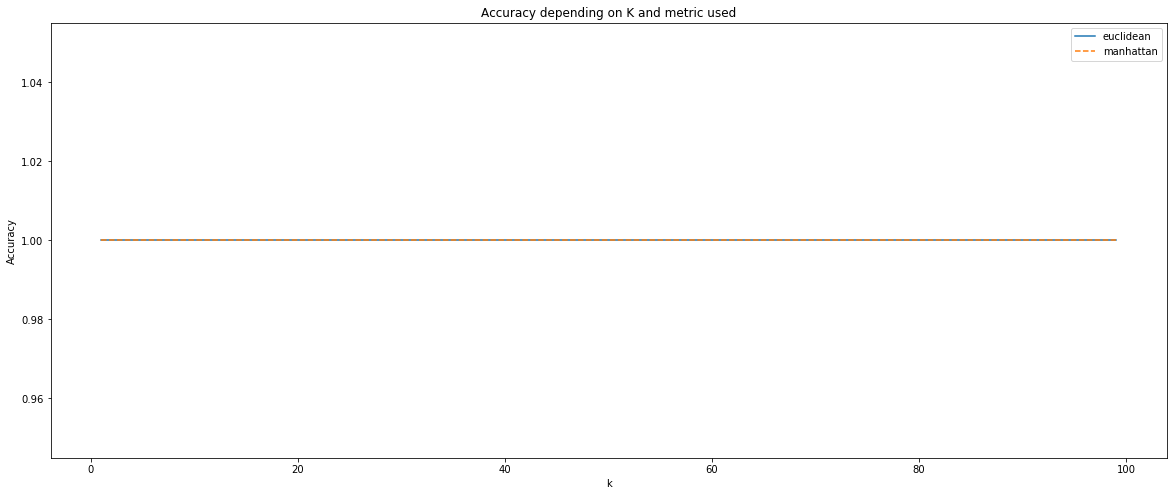

In [58]:
plt.figure(figsize=(20,8))
plt.title('Accuracy depending on K and metric used')
plt.ylabel('Accuracy')
plt.xlabel('k')
linestyles = ['-', '--', '-.', ':']

for i in range(len(df_per_metric)):
    plt.plot(df_per_metric[i]["param_n_neighbors"], df_per_metric[i]["mean_test_Accuracy"], linestyle = linestyles[i], label = metric[i])

plt.legend()
plt.show()

In [59]:
#salva la tabella dei risultati con data + parametri migliori
#chiede da solo in input da tastiera il nome del dataset da usare all'inizio del nome del file

date = time.strftime("%Y%m%d_%H%M%S")
parameter_string = ""
for key in grid.best_params_:
    parameter_name = key
    best = str(grid.best_params_[key])
    parameter_string += parameter_name + "[" + best + "]" + "__"
#to_csv("avg_df_{}.csv".format(date), sep = ";", index = False)
filename = date + "__" + parameter_string
df_results.to_csv(parentdir + "/gridsearches/{}__{}.csv".format(dataset_name, filename), sep = ";", index = False)

### save knn with best params

In [60]:
knn = KNeighborsClassifier(**grid.best_params_)

In [61]:
knn.fit(X_train.reshape(X_train.shape[:2]), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [62]:
path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_knn_" + (
    time.strftime("%Y%m%d_%H%M%S") + ".joblib")
dump(knn, path) 

['./blackbox_checkpoints/cbf_blackbox_knn_20191106_145654.joblib']

### load best knn

In [43]:
knn = load(parentdir + "/blackbox_checkpoints/cbf_blackbox_knn_20191106_145654.joblib")

In [44]:
knn.score(X_test.reshape(X_test.shape[:2]), y_test)

1.0

In [45]:
mean_squared_error(y_test, knn.predict(X_test.reshape(X_test.shape[:2])))

0.0

# AUTOENCODER TRAINING

In [69]:
# TENSORBOARD
# tensorboard --logdir=/tmp/autoencoder
# http://0.0.0.0:6006
# lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

In [39]:
import autoencoders
from autoencoders import *
import importlib
importlib.reload(autoencoders)

<module 'autoencoders' from '/Users/francesco/github/TS_AgnosticLocalExplainer/autoencoders.py'>

## Standard

In [40]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 1)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 128, 2)            44        
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 2)            8         
_________________________________________________________________
activation_13 (Activation)   (None, 128, 2)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 2)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 128, 4)            148       
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 4)            16 

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 128, 1)            0         
_________________________________________________________________
Encoder (Model)              (None, 2)                 166675    
_________________________________________________________________
Decoder (Model)              (None, 128, 1)            264929    
Total params: 431,604
Trainable params: 429,564
Non-trainable params: 2,040
_________________________________________________________________
None


In [41]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [98]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=200, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 115 samples, validate on 29 samples
Epoch 1/200
115/115 [==============================] - 16s 143ms/step - loss: 17.2193 - val_loss: 16.9553

Epoch 00001: val_loss improved from inf to 16.95526, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+16.9553_.hdf5
Epoch 2/200
115/115 [==============================] - 2s 14ms/step - loss: 15.2082 - val_loss: 17.5610

Epoch 00002: val_loss did not improve from 16.95526
Epoch 3/200
115/115 [==============================] - 2s 16ms/step - loss: 14.7568 - val_loss: 15.5239

Epoch 00003: val_loss improved from 16.95526 to 15.52386, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+15.5239_.hdf5
Epoch 4/200
115/115 [==============================] - 2s 17ms/step - loss: 14.4599 - val_loss: 14.5156

Epoch 00004: val_loss improved from 15.52386 to 14.51560, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+14.5156_.hdf5
Epoch 

115/115 [==============================] - 2s 14ms/step - loss: 12.0382 - val_loss: 11.9961

Epoch 00039: val_loss improved from 12.00686 to 11.99609, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+11.9961_.hdf5
Epoch 40/200
115/115 [==============================] - 2s 15ms/step - loss: 11.9877 - val_loss: 11.9166

Epoch 00040: val_loss improved from 11.99609 to 11.91660, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+11.9166_.hdf5
Epoch 41/200
115/115 [==============================] - 2s 14ms/step - loss: 11.9363 - val_loss: 11.8370

Epoch 00041: val_loss improved from 11.91660 to 11.83703, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+11.8370_.hdf5
Epoch 42/200
115/115 [==============================] - 2s 15ms/step - loss: 11.8804 - val_loss: 11.8145

Epoch 00042: val_loss improved from 11.83703 to 11.81447, saving model to ./autoencoder_checkpoints/cbf_autoe

115/115 [==============================] - 2s 14ms/step - loss: 10.3003 - val_loss: 10.3307

Epoch 00072: val_loss improved from 10.38465 to 10.33072, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+10.3307_.hdf5
Epoch 73/200
115/115 [==============================] - 2s 14ms/step - loss: 10.2369 - val_loss: 10.2467

Epoch 00073: val_loss improved from 10.33072 to 10.24673, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+10.2467_.hdf5
Epoch 74/200
115/115 [==============================] - 2s 13ms/step - loss: 10.1930 - val_loss: 10.2206

Epoch 00074: val_loss improved from 10.24673 to 10.22061, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+10.2206_.hdf5
Epoch 75/200
115/115 [==============================] - 2s 14ms/step - loss: 10.1323 - val_loss: 10.1196

Epoch 00075: val_loss improved from 10.22061 to 10.11962, saving model to ./autoencoder_checkpoints/cbf_autoe

115/115 [==============================] - 2s 14ms/step - loss: 8.5104 - val_loss: 8.5083

Epoch 00107: val_loss did not improve from 8.50453
Epoch 108/200
115/115 [==============================] - 2s 13ms/step - loss: 8.4597 - val_loss: 8.4716

Epoch 00108: val_loss improved from 8.50453 to 8.47155, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+8.4716_.hdf5
Epoch 109/200
115/115 [==============================] - 2s 13ms/step - loss: 8.4228 - val_loss: 8.4286

Epoch 00109: val_loss improved from 8.47155 to 8.42858, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+8.4286_.hdf5
Epoch 110/200
115/115 [==============================] - 2s 14ms/step - loss: 8.3692 - val_loss: 8.2430

Epoch 00110: val_loss improved from 8.42858 to 8.24298, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+8.2430_.hdf5
Epoch 111/200
115/115 [==============================] - 2s 14ms/step - 

115/115 [==============================] - 2s 21ms/step - loss: 6.9272 - val_loss: 6.7832

Epoch 00142: val_loss improved from 6.81200 to 6.78315, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+6.7832_.hdf5
Epoch 143/200
115/115 [==============================] - 2s 19ms/step - loss: 6.8875 - val_loss: 6.7224

Epoch 00143: val_loss improved from 6.78315 to 6.72245, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+6.7224_.hdf5
Epoch 144/200
115/115 [==============================] - 2s 20ms/step - loss: 6.8516 - val_loss: 6.7254

Epoch 00144: val_loss did not improve from 6.72245
Epoch 145/200
115/115 [==============================] - 2s 20ms/step - loss: 6.8140 - val_loss: 6.7148

Epoch 00145: val_loss improved from 6.72245 to 6.71475, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+6.7148_.hdf5
Epoch 146/200
115/115 [==============================] - 2s 16ms/step - 

115/115 [==============================] - 2s 20ms/step - loss: 5.6121 - val_loss: 5.5636

Epoch 00177: val_loss improved from 5.64805 to 5.56358, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+5.5636_.hdf5
Epoch 178/200
115/115 [==============================] - 2s 17ms/step - loss: 5.5841 - val_loss: 5.6151

Epoch 00178: val_loss did not improve from 5.56358
Epoch 179/200
115/115 [==============================] - 2s 15ms/step - loss: 5.5572 - val_loss: 5.4949

Epoch 00179: val_loss improved from 5.56358 to 5.49493, saving model to ./autoencoder_checkpoints/cbf_autoencoder_20191106_153308_best_weights_+5.4949_.hdf5
Epoch 180/200
115/115 [==============================] - 2s 17ms/step - loss: 5.5282 - val_loss: 5.4989

Epoch 00180: val_loss did not improve from 5.49493
Epoch 181/200
115/115 [==============================] - 2s 18ms/step - loss: 5.4800 - val_loss: 5.4206

Epoch 00181: val_loss improved from 5.49493 to 5.42061, saving model to .

In [17]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144056_best_weights_+1.0504_.hdf5")


In [49]:
autoencoder.evaluate(X_exp_val, X_exp_val)

29/29 [==============================] - 2s 61ms/step


1.0504339933395386

In [50]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, knn, X_exp_val, keras = False)

1.0

In [51]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False)

1.0

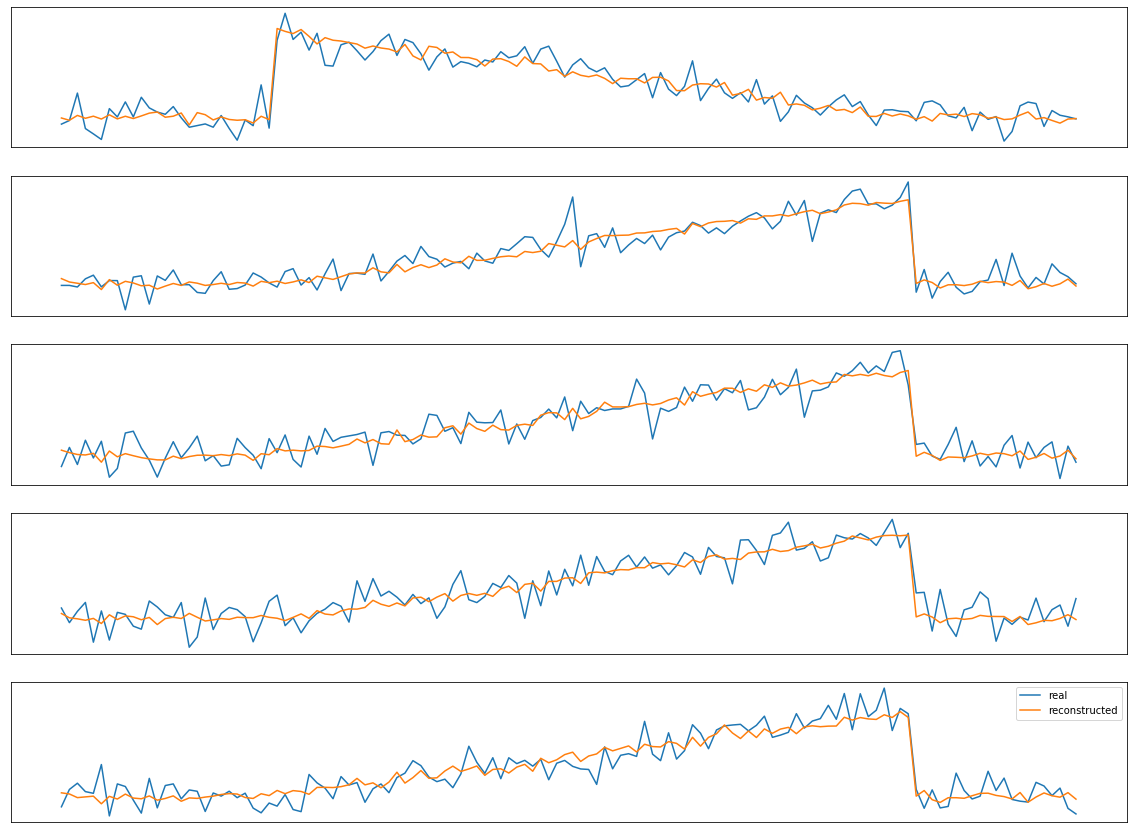

In [52]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## VARIATIONAL

In [17]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()


Model: "VariationalEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 128, 2)       44          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 128, 2)       8           conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 128, 2)       0           batch_normalization_29[0][0]     
________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
up_sampling1d_9 (UpSampling1 (None, 128, 1)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 128, 256)          1024      
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 256)          1024      
_________________________________________________________________
activation_37 (Activation)   (None, 128, 256)          0   

In [520]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [521]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=50, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

In [18]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144909_best_weights_+136.8745_.hdf5")


In [55]:
autoencoder.evaluate(X_exp_val, X_exp_val)

29/29 [==============================] - 3s 91ms/step


[136.19517517089844, 1.0224334001541138]

In [56]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_val)

1.0

In [130]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test)

1.0

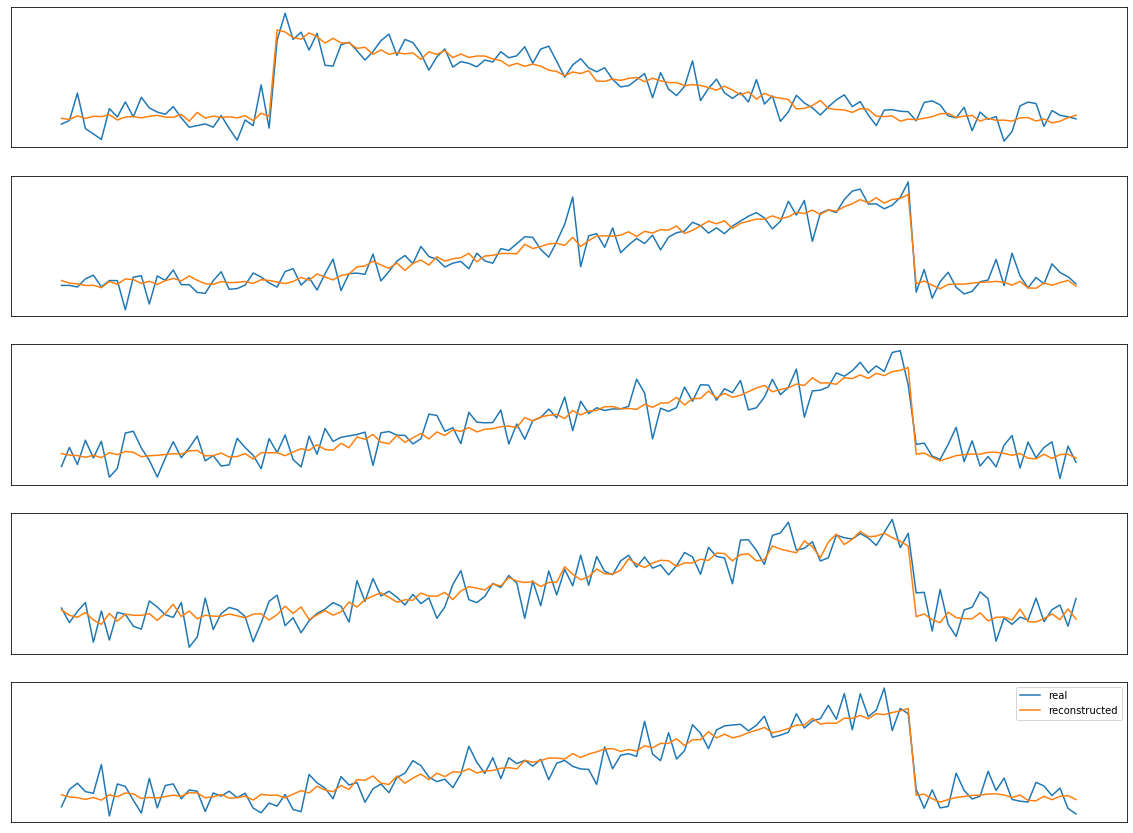

In [57]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## DISCRIMINATIVE STANDARD

In [202]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(**params)
encoder, decoder, discriminator, autoencoder = aut.build()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 128, 1)            0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 128, 2)            44        
_________________________________________________________________
batch_normalization_285 (Bat (None, 128, 2)            8         
_________________________________________________________________
activation_315 (Activation)  (None, 128, 2)            0         
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 128, 2)            0         
_________________________________________________________________
conv1d_310 (Conv1D)          (None, 128, 4)            148       
_________________________________________________________________
batch_normalization_286 (Bat (None, 128, 4)            16  

Model: "Discriminative Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 128, 1)       0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 2)            166675      Input[0][0]                      
__________________________________________________________________________________________________
Decoder (Model)                 (None, 128, 1)       264929      Encoder[1][0]                    
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            10501       Encoder[1][0]                    
Total params: 442,105
Trainable params: 429,564
Non-trainable params: 12,

In [520]:
file_path = parentdir + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_")

to_dict = open(parentdir + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

In [521]:
history = aut.custom_fit(X_exp_train, 
               X_exp_train, 
               epochs = 300, 
               batch_size = 16, 
               val_data = X_exp_val, 
               val_targets = X_exp_val,
               save_checkpoint = "validation_loss",
               filepath = file_path
               )

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

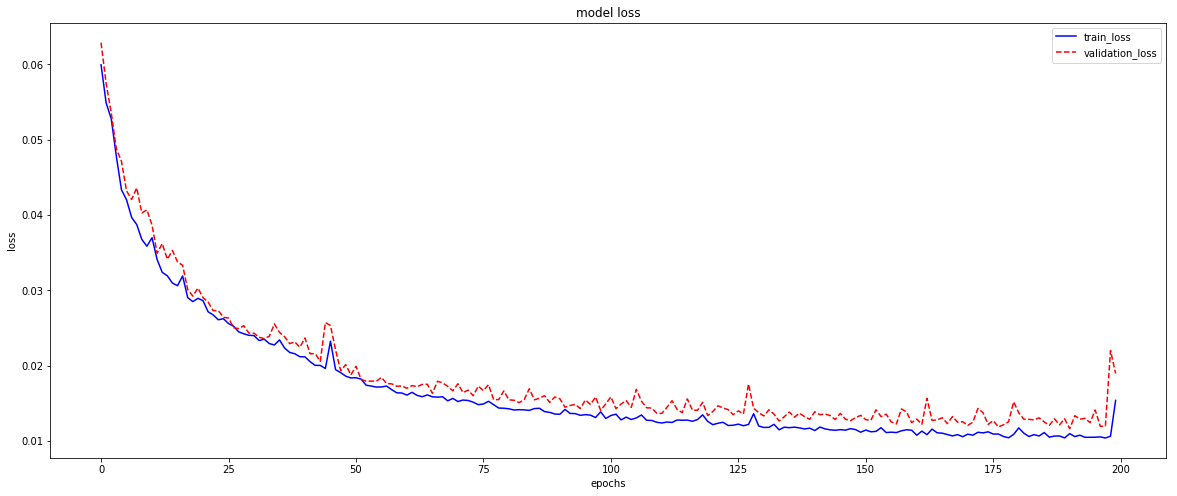

In [207]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history["autoencoder"]["loss"], color = "blue", label = "train_loss")
plt.plot(history["autoencoder"]["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [203]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_150722_best_weights_+1.239848_.hdf5")

In [149]:
mean_squared_error(X_exp_val.flatten(), autoencoder.predict(X_exp_val)[0].flatten())

1.2398483458918996

In [153]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_val, discriminative = True)

1.0

In [154]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test, discriminative = True)

1.0

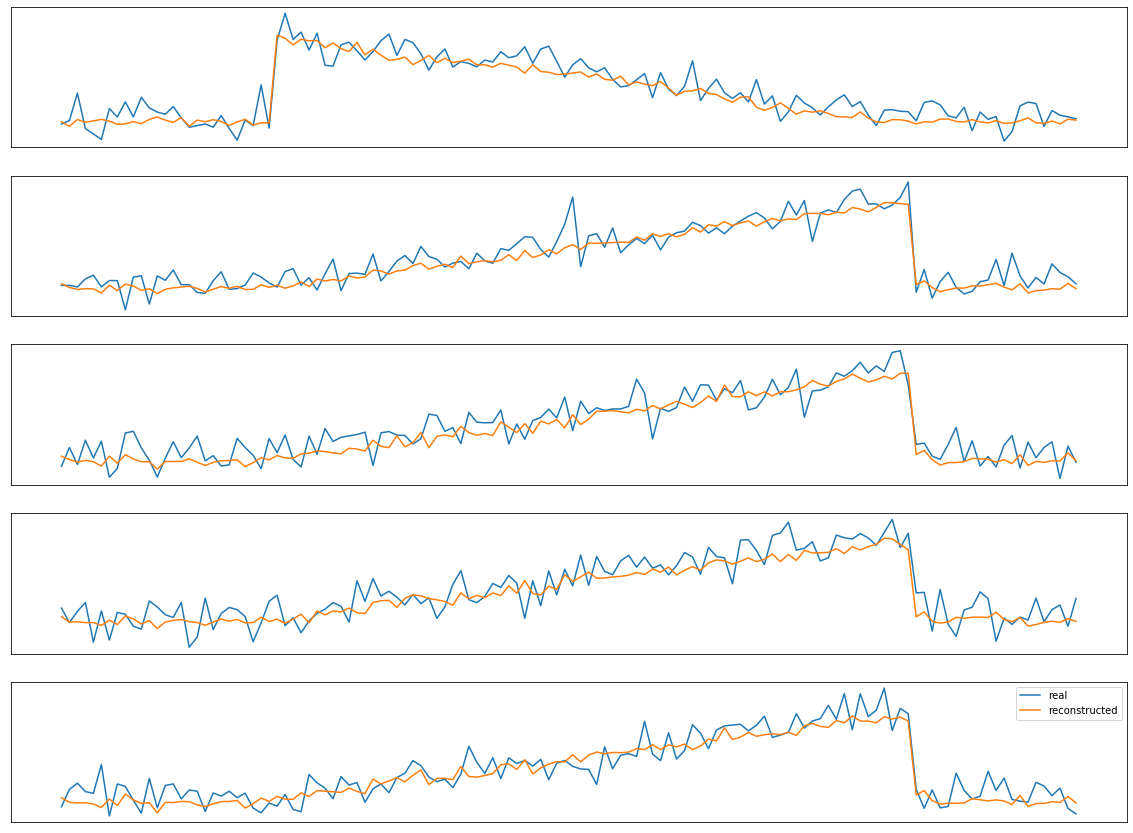

In [150]:
decoded_tss = autoencoder.predict(X_exp_val)[0]
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## DISCRIMINATIVE VARIATIONAL

In [194]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(**params)
encoder, decoder, discriminator, autoencoder = aut.build()

Model: "VariationalEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 128, 1)       0                                            
__________________________________________________________________________________________________
conv1d_291 (Conv1D)             (None, 128, 2)       44          input_37[0][0]                   
__________________________________________________________________________________________________
batch_normalization_269 (BatchN (None, 128, 2)       8           conv1d_291[0][0]                 
__________________________________________________________________________________________________
activation_295 (Activation)     (None, 128, 2)       0           batch_normalization_269[0][0]    
_________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               384       
_________________________________________________________________
reshape_14 (Reshape)         (None, 128, 1)            0         
_________________________________________________________________
up_sampling1d_105 (UpSamplin (None, 128, 1)            0         
_________________________________________________________________
conv1d_300 (Conv1D)          (None, 128, 256)          1024      
_________________________________________________________________
batch_normalization_277 (Bat (None, 128, 256)          1024      
_________________________________________________________________
activation_304 (Activation)  (None, 128, 256)          0   

In [520]:
file_path = parentdir + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_")

to_dict = open(parentdir + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

In [521]:
history = aut.custom_fit(X_exp_train, 
               X_exp_train, 
               epochs = 300, 
               batch_size = 16, 
               val_data = X_exp_val, 
               val_targets = X_exp_val,
               save_checkpoint = "validation_loss",
               filepath = file_path
               )

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

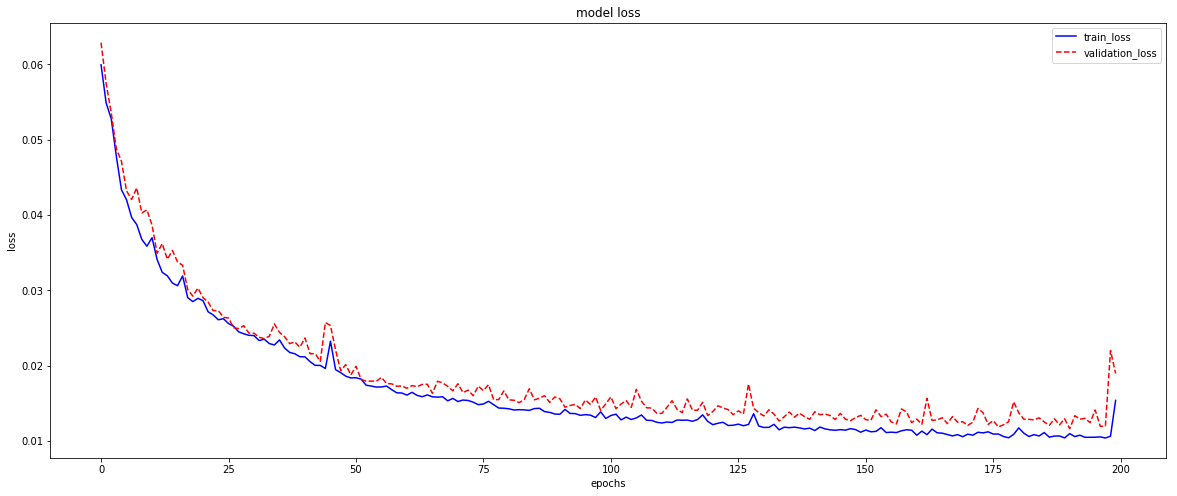

In [207]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history["autoencoder"]["loss"], color = "blue", label = "train_loss")
plt.plot(history["autoencoder"]["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [195]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_153613_best_weights_+1.179660_.hdf5")

In [218]:
mean_squared_error(X_exp_val.flatten(), autoencoder.predict(X_exp_val)[0].flatten())

1.2207323052545538

In [219]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_val, discriminative = True)

0.9655172413793104

In [220]:
### AUTOENCODER SANITY CHECK
### THE RECONSTRUCTED TIME SERIES HAVE THE SAME CLASS AS THE ORIGINAL ONE?
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test, discriminative = True)

1.0

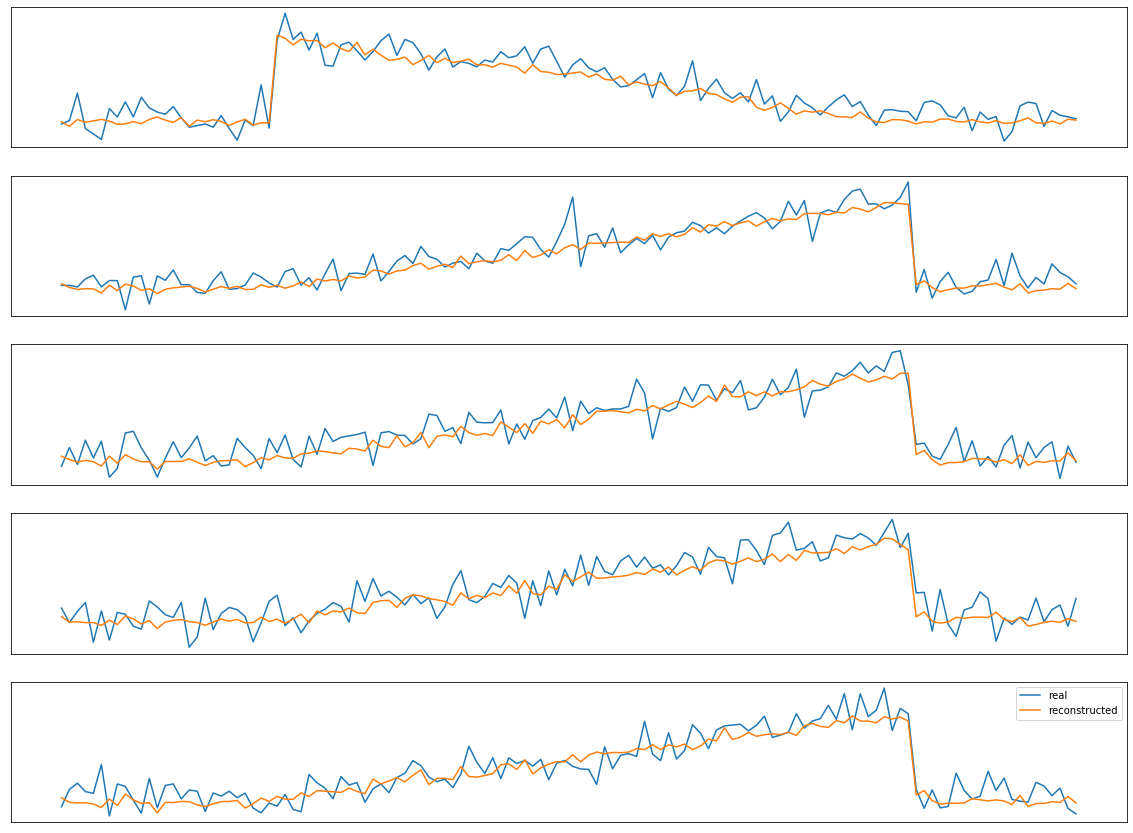

In [222]:
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()